## Sale forecasting with simple LSTM model

### Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datalabframework as dlf
sns.set()

### Importing the dataset

In [2]:
sale_df = pd.read_csv('../inventory_data_generated/sales_1.csv')

In [3]:
sale_df.shape

(12269, 797)

### Getting products' sku_id from pyspark

In [4]:
def start_engine():
    project = dlf.project.load()
    return project.engine()

In [5]:
engine = start_engine()

In [6]:
df = engine.load("fact_table")

INFO:dlf:{'md': {'hash': '0x642212951f4b10b6', 'url': 'hdfs://bigdata-m.teko.vn:18020/teko/prod/etl/fact/fact_table', 'service': 'hdfs', 'format': 'parquet', 'host': 'bigdata-m.teko.vn', 'port': 18020, 'driver': None, 'database': None, 'username': None, 'password': None, 'resource_path': 'fact_table', 'provider_path': '/teko/prod/etl/fact', 'provider_alias': 'fact', 'resource_alias': 'fact_table', 'cache': None, 'date_column': None, 'date_start': None, 'date_end': None, 'date_window': None, 'date_partition': None, 'update_column': None, 'hash_column': None, 'state_column': None, 'options': {}, 'mapping': {}}, 'mode': None, 'records': 5624827, 'columns': 100, 'time': 11.289133865386248, 'time_core': 7.1758585087955, 'time_prep': 4.1132742911577225}


In [7]:
laptop_df = df.select('sku_id', 'sku_name', 'cat_name', 'brand_id', 'brand_name') \
.filter(df.cat_name.like('laptop%')) \
.distinct().orderBy('brand_name').toPandas()

In [8]:
laptop_df.brand_name.unique()

array(['ASUS', 'AVITA', 'Acer', 'Dell', 'Fujitsu', 'HP', 'LG', 'Lenovo',
       'MSI', 'Xiaomi'], dtype=object)

In [9]:
laptop_df.cat_name.unique()

array(['laptop asus win 1.1', 'laptop asus win 2.1',
       'laptop asus option 1.1', 'laptop dell win 1.1',
       'laptop avita win 1.1', 'laptop acer win 1.1',
       'laptop acer option 1.1', 'laptop acer win 2.1',
       'laptop dell option 1.1', 'laptop dell win 2.1',
       'laptop fujitsu option 1.1', 'laptop compaq - hp option 1.1',
       'laptop compaq - hp win 1.1', 'laptop compaq - hp win 2.1',
       'laptop lg option 1.1', 'laptop lg win 1.1',
       'laptop lenovo win 1.1', 'laptop lenovo option 1.1',
       'laptop lenovo win 2.1', 'laptop msi win 1.1',
       'laptop msi option 1.1', 'laptop xiaomi win 1.1'], dtype=object)

In [10]:
laptop_df.head(10)

,sku_id,sku_name,cat_name,brand_id,brand_name
0,1808466,máy tính xách tay/ laptop asus x407ma-bv039t (...,laptop asus win 1.1,2013,ASUS
1,1806204,máy tính xách tay/ laptop asus gl503ge-en021t ...,laptop asus win 1.1,2013,ASUS
2,1809181,máy tính xách tay/ laptop asus s330ua-ey042t (...,laptop asus win 1.1,2013,ASUS
3,1703317,máy tính xách tay/ laptop asus ux430un-gv081t ...,laptop asus win 1.1,2013,ASUS
4,18110263,máy tính xách tay/ laptop asus b9440ua-gv0495t...,laptop asus win 1.1,2013,ASUS
5,1703192,máy tính xách tay/ laptop asus s410ua-eb220t (...,laptop asus win 1.1,2013,ASUS
6,1703123,máy tính xách tay/ laptop asus tp410ua-ec250t ...,laptop asus win 2.1,2013,ASUS
7,1603267,máy tính xách tay/ laptop asus ux390ua-gs036t ...,laptop asus win 1.1,2013,ASUS
8,1602551,máy tính xách tay/ laptop asus g752vs-gc175t (...,laptop asus win 1.1,2013,ASUS
9,1603270,máy tính xách tay/ laptop asus a456ur-wx044d (...,laptop asus option 1.1,2013,ASUS


In [11]:
engine.stop()

In [12]:
laptop_df.shape

(1362, 5)

### Computing total sale for specific products

In [13]:
laptop_sale_df = sale_df.loc[sale_df.sku_id.isin(laptop_df.sku_id), :]

In [14]:
laptop_sale_df.shape

(1297, 797)

In [15]:
laptop_total_sale = laptop_sale_df.sum(axis = 0)[1:]

In [16]:
laptop_total_sale.head(10)

2017-01-01     86.0
2017-01-02    105.0
2017-01-03    102.0
2017-01-04    113.0
2017-01-05     97.0
2017-01-06     82.0
2017-01-07    103.0
2017-01-08    114.0
2017-01-09     94.0
2017-01-10     83.0
dtype: float64

### Handling missing data

In [17]:
from datetime import date, timedelta
start_date = date(2017, 1, 1)
end_date = date(2019, 3, 12)
n_days = (end_date - start_date).days + 1

In [18]:
ordered_index = []
for i in range (n_days):
    day = (start_date + timedelta(i)).strftime('%Y-%m-%d')
    ordered_index.append(day)
    if (day not in laptop_total_sale.index) or laptop_total_sale[day] == 0:
        # previous_day = (start_date + timedelta(i - 1)).strftime('%Y-%m-%d')
        previous_week_day = [(start_date + timedelta(j)).strftime('%Y-%m-%d') for j in range (i - 7, i)]
        # laptop_total_sale[day] = 0
        # laptop_total_sale[day] = laptop_total_sale[previous_day]
        laptop_total_sale[day] = laptop_total_sale[previous_week_day].mean().round()
        print(day, laptop_total_sale[day])

2017-01-26 102.0
2017-01-27 103.0
2017-01-28 104.0
2017-01-29 100.0
2017-01-30 99.0
2017-01-31 97.0
2017-02-01 98.0
2018-02-14 74.0
2018-02-15 72.0
2018-02-16 73.0
2018-02-17 74.0
2018-02-18 73.0
2018-02-19 72.0
2018-02-20 71.0
2019-02-03 126.0
2019-02-04 127.0
2019-02-05 131.0
2019-02-06 127.0
2019-02-07 125.0
2019-02-08 123.0
2019-02-09 122.0


In [19]:
laptop_total_sale.tail(10)

2018-02-17     74.0
2018-02-18     73.0
2018-02-19     72.0
2018-02-20     71.0
2019-02-03    126.0
2019-02-04    127.0
2019-02-05    131.0
2019-02-06    127.0
2019-02-07    125.0
2019-02-08    123.0
dtype: float64

In [20]:
laptop_total_sale = laptop_total_sale[ordered_index]

In [21]:
laptop_total_sale.index = pd.to_datetime(laptop_total_sale.index)

### Visualising total data

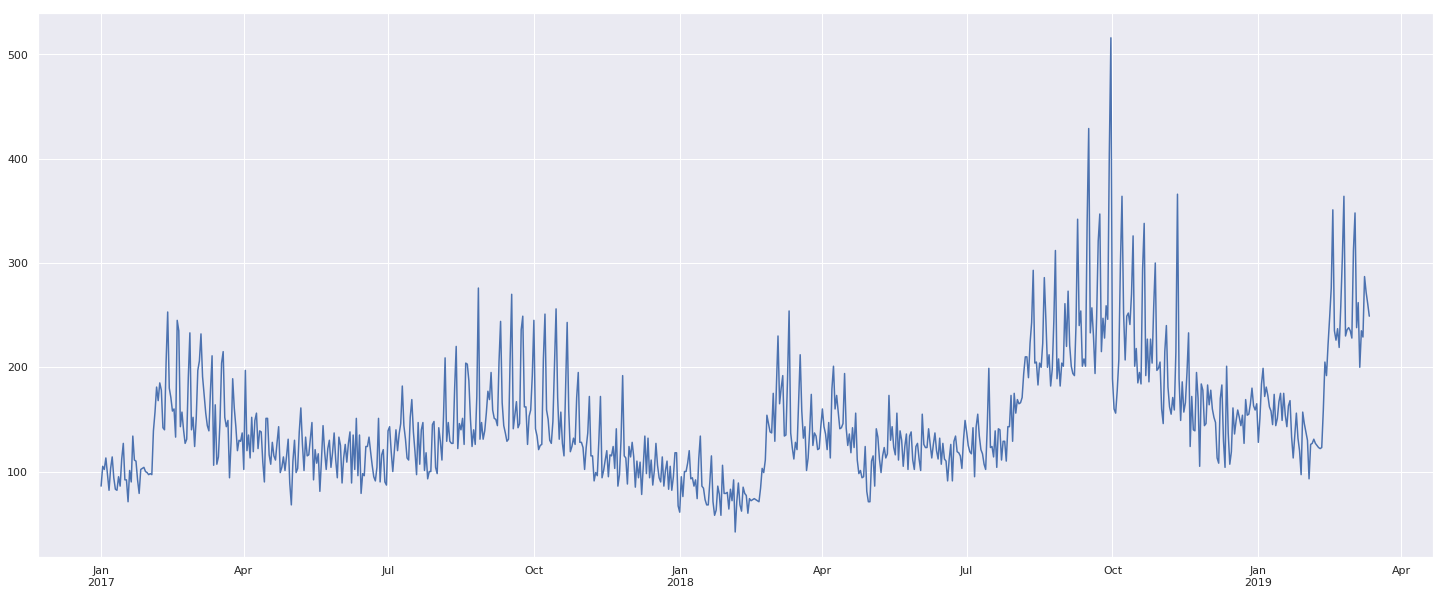

In [22]:
laptop_total_sale.plot(figsize = (25, 10), use_index = True);

### Spliting data into training and test set

In [23]:
training_set = laptop_total_sale[:-60]
test_set = laptop_total_sale[-60:]

In [24]:
test_set.shape

(60,)

### Feature scaling

In [25]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))

training_set_scaled = sc.fit_transform(training_set.values.reshape(-1, 1))

In [26]:
training_set_scaled.shape

(741, 1)

### Create data structure with several timesteps

In [27]:
n_timesteps = 7
n_training_samples = training_set_scaled.shape[0]

X_train = []
y_train = []

for i in range (n_timesteps, n_training_samples):
    X_train.append(training_set_scaled[i - n_timesteps: i])
    y_train.append(training_set_scaled[i])
    
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [28]:
X_train.shape

(734, 7, 1)

In [29]:
inputs = laptop_total_sale[len(laptop_total_sale) - len(test_set) - n_timesteps:].values.reshape((-1, 1))
inputs = sc.transform(inputs)

X_val = []
y_val = []

n_input_samples = inputs.shape[0]

for i in range(n_timesteps, n_input_samples):
    X_val.append(inputs[i - n_timesteps: i, 0])
    y_val.append(inputs[i, 0])

X_val, y_val = np.array(X_val), np.array(y_val)

X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

In [30]:
X_val.shape

(60, 7, 1)

### Importing keras

In [31]:
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Building LSTM model for sale forecasting

In [32]:
# Initialising the RNN
regressor = Sequential()

regressor.add(LSTM(units = 32, activation = 'relu', input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

#regressor.add(LSTM(units = 50, activation = 'relu'))
#regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [33]:
regressor.compile(optimizer = 'adam', loss = 'mse')

In [34]:
training_history = regressor.fit(X_train, y_train, epochs = 300, batch_size = 32, validation_data = (X_val, y_val))

Instructions for updating:
Use tf.cast instead.


Train on 734 samples, validate on 60 samples
Epoch 1/300
734/734 [==============================] - 1s 1ms/step - loss: 0.0444 - val_loss: 0.0572
Epoch 2/300
734/734 [==============================] - 0s 375us/step - loss: 0.0138 - val_loss: 0.0162
Epoch 3/300
734/734 [==============================] - 0s 381us/step - loss: 0.0108 - val_loss: 0.0178
Epoch 4/300
734/734 [==============================] - 0s 383us/step - loss: 0.0097 - val_loss: 0.0159
Epoch 5/300
734/734 [==============================] - 0s 375us/step - loss: 0.0090 - val_loss: 0.0136
Epoch 6/300
734/734 [==============================] - 0s 383us/step - loss: 0.0083 - val_loss: 0.0123
Epoch 7/300
734/734 [==============================] - 0s 380us/step - loss: 0.0074 - val_loss: 0.0091
Epoch 8/300
734/734 [==============================] - 0s 389us/step - loss: 0.0071 - val_loss: 0.0081
Epoch 9/300
734/734 [==============================] - 0s 386us/step - loss: 0.0066 - val_loss: 0.0076
Epoch 10/300
734/734 [========

In [190]:
regressor.save('training_model_1.h5')

### Loss

In [35]:
loss = training_history.history['loss']
val_loss = training_history.history['val_loss']

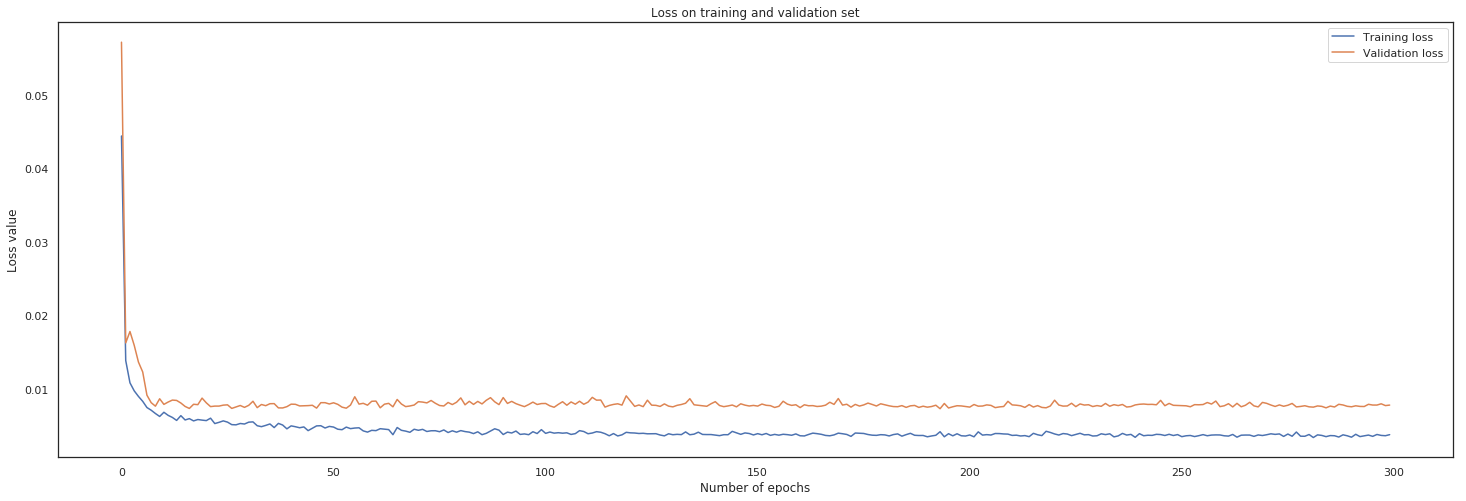

In [36]:
sns.set_style('white')
fig, ax = plt.subplots(figsize = (25, 8))

ax.plot(loss, label = 'Training loss')
ax.plot(val_loss, label = 'Validation loss')
ax.set_title('Loss on training and validation set')
ax.set_xlabel('Number of epochs')
ax.set_ylabel('Loss value')
ax.legend()

plt.show();

### Making prediction

In [37]:
real_sale_number = test_set[:].values

In [38]:
real_sale_number.shape

(60,)

In [39]:
real_sale_number = sc.inverse_transform(y_val.reshape(-1, 1))
real_sale_number = np.reshape(real_sale_number, (real_sale_number.shape[0],))

In [40]:
inputs = training_set_scaled[-n_timesteps:]
n_test = test_set.shape[0]

for i in range(n_test):
    X_test = [inputs[-n_timesteps:]]
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    y_pred_i = regressor.predict(X_test)
    inputs = np.append(inputs, y_pred_i, axis = 0)
    
y_pred = inputs[-n_test:]

In [41]:
y_val_pred = regressor.predict(X_val)

In [42]:
predicted_sale_number_val = sc.inverse_transform(y_val_pred)
predicted_sale_number_val = np.reshape(predicted_sale_number_val, (predicted_sale_number_val.shape[0],))
predicted_sale_number_val = np.round(predicted_sale_number_val)

In [43]:
predicted_sale_number = sc.inverse_transform(y_pred)
predicted_sale_number = np.reshape(predicted_sale_number, (predicted_sale_number.shape[0],))
predicted_sale_number = np.round(predicted_sale_number)

In [44]:
predicted_sale_number.shape

(60,)

### Visualisation of prediction

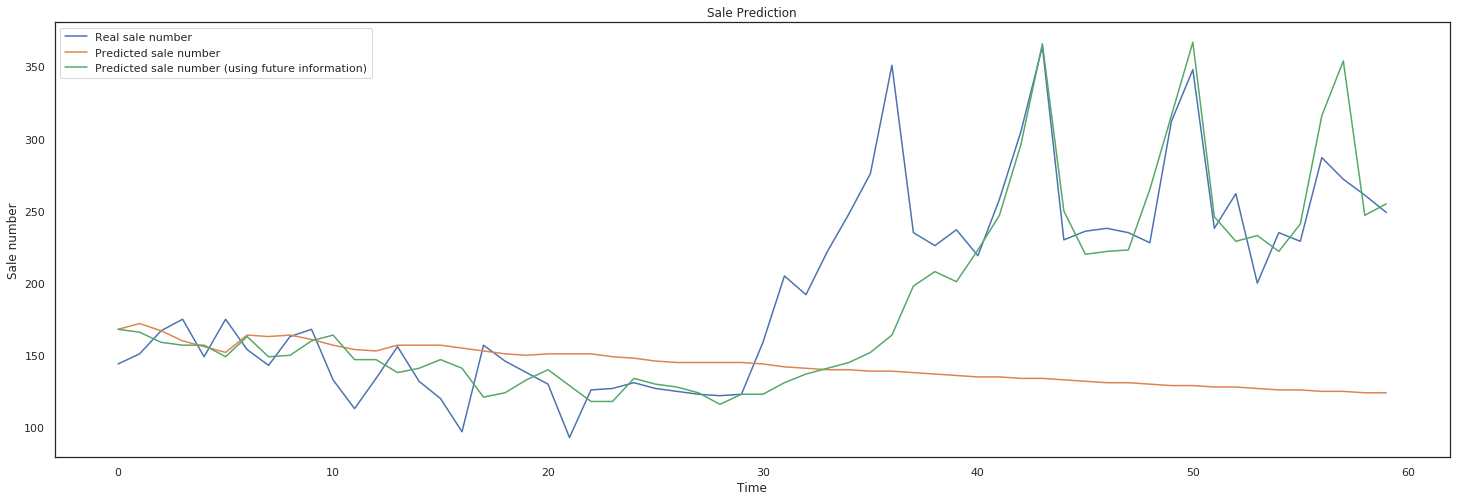

In [45]:
sns.set_style('white')
fig, ax = plt.subplots(figsize = (25, 8))

ax.plot(real_sale_number, label = 'Real sale number')
ax.plot(predicted_sale_number, label = 'Predicted sale number')
ax.plot(predicted_sale_number_val, label = 'Predicted sale number (using future information)')
ax.set_title('Sale Prediction')
ax.set_xlabel('Time')
ax.set_ylabel('Sale number')
ax.legend()

plt.show();

### Error

In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae, mse = mean_absolute_error(real_sale_number, predicted_sale_number), mean_squared_error(real_sale_number, predicted_sale_number)
print("Mean absolute error:", mae)
print("Mean squared error:", mse)

Mean absolute error: 69.63333333333334
Mean squared error: 8540.2


In [47]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [48]:
mape = mean_absolute_percentage_error(real_sale_number, predicted_sale_number)
print("Mean absolute percentage error:", mape)

Mean absolute percentage error: 30.90182610891165


In [49]:
mae = mean_absolute_error(real_sale_number, predicted_sale_number_val)
mse = mean_squared_error(real_sale_number, predicted_sale_number_val)
mape = mean_absolute_percentage_error(real_sale_number, predicted_sale_number_val)
print("Mean absolute error:", mae)
print("Mean squared error:", mse)
print("Mean absolute percentage error:", mape)

Mean absolute error: 26.4
Mean squared error: 1745.3666666666666
Mean absolute percentage error: 13.364399983642391
